In [65]:
import numpy as np
import matplotlib.pyplot as plt
import control as ct
from numpy import array
import scienceplots

np.set_printoptions(precision=3, suppress=True)

plt.style.use([
    'grid',
    'retro'
])

In [66]:
m_v = 1500
J_v = 2400
m_d = 100
m_t = 100

M = np.diag([m_v, J_v, m_d, m_t])

c_sd = 2000
c_st = 2000

l_d  = 1.17
l_t  = 1.68

C = array([
    [c_sd+c_st, l_d*c_sd-l_t*c_st, -c_sd, -c_st],
    [l_d*c_sd-l_t*c_st, l_d**2*c_sd+l_t**2*c_st, -l_d*c_sd, l_t*c_st],
    [-c_sd, -l_d*c_sd, c_sd, 0],
    [-c_st, l_t*c_st, 0, c_st]
])

k_sd = 30000
k_st = 30000
kd   = 300000
kt   = 300000

K = array([
    [k_sd+k_st, l_d*k_sd-l_t*k_st, -k_sd, -k_st],
    [l_d*k_sd-l_t*k_st, l_d**2*k_sd+l_t**2*k_st, -l_d*k_sd, l_t*k_st],
    [-k_sd, -l_d*k_sd, k_sd+kd, 0],
    [-k_st, l_t*k_st, 0, k_st+kt]
])

N = M.shape[0]

In [67]:
A = np.block([
    [np.zeros((N, N)), np.eye(N)],
    [-np.linalg.inv(M)@K, -np.linalg.inv(M)@C]
])

B = np.block([
    [np.zeros((N, N))],
    [np.linalg.inv(M)]
])

C = np.eye(2*N)
D = np.zeros((2*N, N))

sys = ct.ss(A, B, C, D)

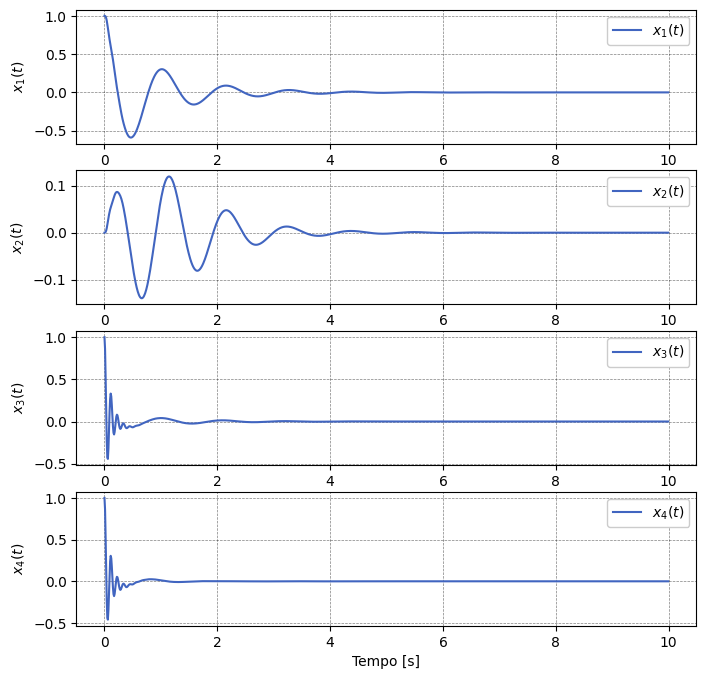

In [68]:
sampling_period = 1e-2
samples = 1000

t = np.arange(0, samples*sampling_period, sampling_period)

U = np.zeros((N, t.shape[0]))

X0 = np.array([1, 0, 1, 1, 0, 0, 0, 0])

t, y = ct.forced_response(sys, t, U, X0=X0)
fig, ax = plt.subplots(N, 1, figsize=(8, 8))

sims.append(y)

for i in range(N):
    ax[i].plot(t, y[i, :], label=f'$x_{i+1}(t)$')
    ax[i].set_ylabel(f'$x_{i+1}(t)$')
    ax[i].legend()

plt.xlabel('Tempo [s]')
plt.savefig('half_car_olc.png', dpi=300, bbox_inches='tight')


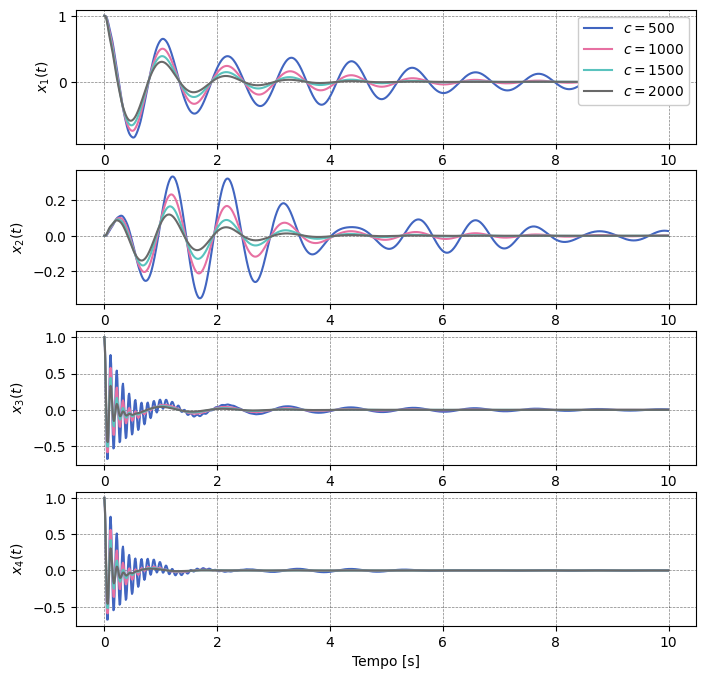

In [96]:
fig, ax = plt.subplots(N, 1, figsize=(8, 8))

r=0
c=0

for i in range(len(sims)):
    for j in range(N):
        ax[j].plot(t, sims[i][j, :], label=f'$x_{i+1}(t)$')
        ax[j].set_ylabel(f'$x_{j+1}(t)$')
        

ax[0].legend(['$c=500$', '$c=1000$', '$c=1500$', '$c=2000$'], loc='upper right')

plt.xlabel('Tempo [s]')
plt.savefig('half_car_olc.png', dpi=300, bbox_inches='tight')